# **Rent the Runway Web Scraping**

In [ ]:
!apt-get install python3-dev libmysqlclient-dev > /dev/null
!pip install mysqlclient > /dev/null
!pip install -U sql_magic > /dev/null
!pip install psycopg2-binary > /dev/null

!pip install -U 'sqlalchemy<2.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.29
    Uninstalling SQLAlchemy-2.0.29:
      Successfully uninstalled SQLAlchemy-2.0.29
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import requests

### **Connection to our SQL Database**

In [ ]:
#set up connection to SQL database (reference the mySQL notebook prof. sedoc built for us!)

def connect_mysql():
    conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
        user='WeatherToWear',
        password='6u36kMD9akk=',
        host='jsedocc7.scrc.nyu.edu',
        port=3306,
        db='WeatherToWear'
    )
    engine = create_engine(conn_string)
    return engine

In [ ]:
#create inventory table, execute command, and then disconnect

def create_inventory_table(engine):
    with engine.connect() as conn:
        conn.execute("""
            CREATE TABLE IF NOT EXISTS inventory(
                `index` INT AUTO_INCREMENT PRIMARY KEY,
                `id` TEXT NOT NULL,
                `category` TEXT,
                `image` TEXT,
                `displayName` TEXT,
                `urlHistory` TEXT
            )
        """)

### **Scraping RTR**

In [ ]:
#retrieve data from RTR

def get_category(engine, category):
    has_next_page = True
    current_page = 1

    if category == 'dresses':
        url = 'https://www.renttherunway.com/c/'
    else:
        url = 'https://www.renttherunway.com/products/clothing/'

    while has_next_page:
        response = requests.get(url+category,
            params={'filters[zip_code]': '10010', 'page': current_page},
            headers={'accept': 'application/json, text/javascript, */*; q=0.01', 'x-requested-with': 'XMLHttpRequest'})
        json_response = response.json()
        products = json_response['products']
        total_pages = json_response['totalPages']
        next_page = json_response['next_page']

        with engine.connect() as conn:
            for product in products:
                try:
                    product['images']['front']
                    conn.execute("""
                        INSERT INTO inventory (id, category, image, displayName, urlHistory)
                        VALUES (%s, %s, %s, %s, %s)
                    """, (product['id'], category, product['images']['front']['270x'], product['displayName'], product['urlHistory'][-1]))
                except Exception as e:
                  print(f"Error: {e}")
                  continue

        print(category)
        print(f'Current page: {current_page}')
        print(f'Number of products collected: {len(products)}')
        print(f'Pages left: {total_pages-current_page}')

        if next_page:
            has_next_page = True
            current_page += 1
        else:
            has_next_page = False

In [ ]:
#execute code
engine=connect_mysql()
create_inventory_table(engine)
categories=['top','bottom','dresses','jumpsuit_romper','knit','jacket_coat']
for category in categories:
  get_category(engine, category)

<ipython-input-4-a0f3f6e35120>:5: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  conn.execute("""


top
Current page: 1
Number of products collected: 60
Pages left: 18
top
Current page: 2
Number of products collected: 60
Pages left: 18
top
Current page: 3
Number of products collected: 60
Pages left: 19
top
Current page: 4
Number of products collected: 60
Pages left: 18
top
Current page: 5
Number of products collected: 60
Pages left: 17
top
Current page: 6
Number of products collected: 60
Pages left: 16
top
Current page: 7
Number of products collected: 60
Pages left: 15
top
Current page: 8
Number of products collected: 60
Pages left: 15
top
Current page: 9
Number of products collected: 60
Pages left: 14
top
Current page: 10
Number of products collected: 60
Pages left: 13
top
Current page: 11
Number of products collected: 60
Pages left: 12
top
Current page: 12
Number of products collected: 60
Pages left: 11
top
Current page: 13
Number of products collected: 60
Pages left: 10
top
Current page: 14
Number of products collected: 60
Pages left: 9
top
Current page: 15
Number of products coll

KeyboardInterrupt: 

In [ ]:
#read the database and create a dataframe with RTR data
conn=connect_mysql()
inventory_df=pd.read_sql('SELECT * FROM inventory', conn)
prefix = 'https://pc-ap.rtrcdn.com/'
inventory_df['image']=inventory_df['image'].apply(lambda x: prefix + x)
print(inventory_df)

       index      id category  \
0          1  HOFC57      top   
1          2    ENS4      top   
2          3   BUP47      top   
3          4  MDW376      top   
4          5  ALC291      top   
...      ...     ...      ...   
84287  84290   RDN23   bottom   
84288  84291   DLD75   bottom   
84289  84292  MISA85   bottom   
84290  84293   GAN59   bottom   
84291  84294  DVF427   bottom   

                                                   image  \
0      https://pc-ap.rtrcdn.com/productimages/front/2...   
1      https://pc-ap.rtrcdn.com/productimages/front/2...   
2      https://pc-ap.rtrcdn.com/productimages/front/2...   
3      https://pc-ap.rtrcdn.com/productimages/front/2...   
4      https://pc-ap.rtrcdn.com/productimages/front/2...   
...                                                  ...   
84287  https://pc-ap.rtrcdn.com/productimages/front/2...   
84288  https://pc-ap.rtrcdn.com/productimages/front/2...   
84289  https://pc-ap.rtrcdn.com/productimages/front/2...   
842

In [ ]:
inventory_df.head(3)

,index,id,category,image,displayName,urlHistory,style,weather,color
0,1,HOFC57,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Mika Top,http://www.renttherunway.com/shop/designers/ho...,bohemian,breathable,patterned
1,2,ENS4,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Cece Top,http://www.renttherunway.com/shop/designers/en...,chic,breathable,white
2,3,BUP47,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Celly Top,http://www.renttherunway.com/shop/designers/ba...,chic,breathable,white


In [ ]:
inventory_df.tail(3)

,index,id,category,image,displayName,urlHistory,style,weather,color
84289,84292,MISA85,bottom,https://pc-ap.rtrcdn.com/productimages/front/2...,Sara Eyelet Skirt,http://www.renttherunway.com/shop/designers/mi...,None,None,None
84290,84293,GAN59,bottom,https://pc-ap.rtrcdn.com/productimages/front/2...,Pinstripe Pants,http://www.renttherunway.com/shop/designers/ga...,None,None,None
84291,84294,DVF427,bottom,https://pc-ap.rtrcdn.com/productimages/front/2...,Coretta Skirt,http://www.renttherunway.com/shop/designers/di...,None,None,None


In [ ]:
inventory_df.sample(3)

,index,id,category,image,displayName,urlHistory,style,weather,color
45906,45907,LOU193,dresses,https://pc-ap.rtrcdn.com/productimages/front/2...,Yellow Cinched Dress,http://www.renttherunway.com/shop/designers/lo...,None,None,None
61120,61121,LRL225,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Drewty Vest,http://www.renttherunway.com/shop/designers/la...,None,None,None
43341,43342,SNY117,bottom,https://pc-ap.rtrcdn.com/productimages/front/2...,Alicia Skirt,http://www.renttherunway.com/shop/designers/se...,None,None,None


### **Categorizing Images**

In [ ]:
## STYLE
!pip install mysqlclient
!pip install pymysql

import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
from transformers import CLIPProcessor, CLIPModel
import torch
import json  # to handle conversion of dictionary to string

# Initialize the CLIP model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to connect to the SQL database
def connect_mysql():
    conn_string = 'mysql+mysqldb://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
        user='WeatherToWear',
        password='6u36kMD9akk=',
        host='jsedocc7.scrc.nyu.edu',
        port=3306,
        db='WeatherToWear'
    )
    engine = create_engine(conn_string)
    return engine

conn = connect_mysql()

# retrieving inventory from the database
inventory_df = pd.read_sql('SELECT * FROM inventory', conn)

# Define style attributes for classification
style_attributes = [
    "classy", "casual", "modern", "vintage", "sophisticated", "chic", "trendy",
    "timeless", "fashionable", "sleek", "stylish", "glamorous", "edgy", "bohemian",
    "refined", "polished", "avant-garde", "eclectic", "effortless", "urban", "couture"]

# Function to classify image style with correct URL and image processing
def classify_image_style(image_url):
    base_url = "https://pc-ap.rtrcdn.com/"
    full_url = base_url + image_url
    try:
        response = requests.get(full_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(text=style_attributes, images=image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1).squeeze().tolist()
        style_scores = dict(zip(style_attributes, probs))
        return style_scores
    except Exception as e:
        print(f"Error processing image at {full_url}: {e}")
        return None

# Function to update the database with the style attribute
def update_style(engine, index, style_scores):
    style_scores_json = json.dumps(style_scores)
    with engine.connect() as conn:
        conn.execute(text("""
            UPDATE inventory
            SET style_scores = :style_scores
            WHERE `index` = :index
        """), {'style_scores': style_scores_json, 'index': index})

for index, row in inventory_df.iterrows():
    style_scores = classify_image_style(row['image'])
    if style_scores:
        update_style(conn, row['index'], style_scores)
        print(f"Updated {row['displayName']} with style scores.")
    else:
        print(f"Skipped updating {row['displayName']} due to errors.")

# Close the database connection
conn.dispose()


  Using cached mysqlclient-2.2.4.tar.gz (90 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mysqlclient: filename=mysqlclient-2.2.4-cp310-cp310-linux_x86_64.whl size=124732 sha256=4a3f9bd0d2902d52c1327478db6e583a90a9924bb69b8de4a8e7a81170df29fb
  Stored in directory: /root/.cache/pip/wheels/ac/96/ac/2a4d8cb58a4d95de1dffc3f8b0ea42e0e5b63ab97640edbda3
Successfully built mysqlclient
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

OperationalError: (MySQLdb.OperationalError) (1054, "Unknown column 'style_scores' in 'field list'")
[SQL: 
            UPDATE inventory
            SET style_scores = %s
            WHERE `index` = %s
        ]
[parameters: ('{"classy": 0.03846010938286781, "casual": 0.009431727230548859, "modern": 0.012961541302502155, "vintage": 0.05200646072626114, "sophisticated": 0.00 ... (397 characters truncated) ... 022900919429957867, "eclectic": 0.01962260715663433, "effortless": 0.0223216712474823, "urban": 0.003675989340990782, "couture": 0.17179974913597107}', 1)]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
## WEATHER
!pip install mysqlclient
!pip install pymysql


import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel
import torch

# Initialize the CLIP model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Function to connect to the SQL database
def connect_mysql():
    conn_string = 'mysql+mysqldb://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
        user='WeatherToWear',
        password='6u36kMD9akk=',
        host='jsedocc7.scrc.nyu.edu',
        port=3306,
        db='WeatherToWear'
    )
    engine = create_engine(conn_string)
    return engine

conn = connect_mysql()

#  retrieving inventory from the database
inventory_df = pd.read_sql('SELECT * FROM inventory', conn)

# define weather attributes for classification
weather_attributes = ["waterproof", "breathable", "sleeveless", "insulated", "windproof", "lightweight", "layered", "all-season"]

# Function to classify image weather with correct URL and image processing
def classify_image_weather(image_url, descriptionList):
    base_url = "https://pc-ap.rtrcdn.com/"
    full_url = base_url + image_url
    try:
        response = requests.get(full_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(text= descriptionList, images=image, return_tensors="pt", padding = True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        print(probs)
        results = dict(zip(descriptionList, probs.tolist()[0]))
        print(results)
        return max(results, key=results.get)
    except Exception as e:
        print(f"Error processing image at {full_url}: {e}")
        return None

# Function to update the database with the weather attribute
def update_weather(engine, index, weather):
    print(weather, index)
    print(f"""
            UPDATE inventory
            SET weather = {weather}
            WHERE `index` = {index}
""")
    with engine.connect() as conn:
        conn.execute(text(f""" UPDATE inventory SET weather = "{weather}" WHERE `index` = {index}"""))



# Classify and update images
for index, row in inventory_df.iterrows():
    if pd.isnull(row['weather']):  # Check if weather is null
        weather = classify_image_weather(row['image'], ["waterproof", "breathable", "insulated", "windproof", "lightweight", "layered", "all-season"])
        if weather:
            update_weather(conn, row['index'], weather)
            print(f"Updated {row['displayName']} with weather {weather}")
        else:
            print(f"Skipped updating {row['displayName']} due to errors.")
    else:
        print(f"Skipping {row['displayName']} because weather value already exists.")


# Close the database connection
conn.dispose()

In [ ]:
## COLORS
!pip install mysqlclient
!pip install pymysql


import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel
import torch

# Initialize the CLIP model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")



# Function to connect to the SQL database
def connect_mysql():
    conn_string = 'mysql+mysqldb://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
        user='WeatherToWear',
        password='6u36kMD9akk=',
        host='jsedocc7.scrc.nyu.edu',
        port=3306,
        db='WeatherToWear'
    )
    engine = create_engine(conn_string)
    return engine

conn = connect_mysql()

#  retrieving inventory from the database
inventory_df = pd.read_sql('SELECT * FROM inventory', conn)

# define color attributes for classification
color_attributes = ["pastel", "dark", "light", "black", "white", "multicolored", "patterned", "earthy", "neutral"]

# Function to classify image color with correct URL and image processing
def classify_image_color(image_url, descriptionList):
    base_url = "https://pc-ap.rtrcdn.com/"
    full_url = base_url + image_url
    try:
        response = requests.get(full_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = processor(text= descriptionList, images=image, return_tensors="pt", padding = True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        print(probs)
        results = dict(zip(descriptionList, probs.tolist()[0]))
        print(results)
        return max(results, key=results.get)
    except Exception as e:
        print(f"Error processing image at {full_url}: {e}")
        return None

# Function to update the database with the color attribute
def update_color(engine, index, color):
    print(color, index)
    print(f"""
            UPDATE inventory
            SET color = {color}
            WHERE `index` = {index}
""")
    with engine.connect() as conn:
        conn.execute(text(f""" UPDATE inventory SET color = "{color}" WHERE `index` = {index}"""))



# Classify and update images
for index, row in inventory_df.iterrows():
    if pd.isnull(row['color']):
        color = classify_image_color(row['image'], ["pastel", "dark", "light", "black", "white", "multicolored", "patterned", "earthy", "neutral"])
        if color:
            update_color(conn, row['index'], color)
            print(f"Updated {row['displayName']} with color {color}")
        else:
            print(f"Skipped updating {row['displayName']} due to errors.")
    else:
        print(f"Skipping {row['displayName']} because color value already exists.")


# Close the database connection
conn.dispose()

### **Data Analysis**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# 1. Basic Information
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82591 entries, 0 to 82590
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        82591 non-null  int64 
 1   id           82591 non-null  object
 2   category     82591 non-null  object
 3   image        82591 non-null  object
 4   displayName  82591 non-null  object
 5   urlHistory   82591 non-null  object
 6   style        28478 non-null  object
 7   weather      29981 non-null  object
 8   color        163 non-null    object
dtypes: int64(1), object(8)
memory usage: 5.7+ MB


In [ ]:
inventory_df.head()

,index,id,category,image,displayName,urlHistory,style,weather,color
0,1,HOFC57,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Mika Top,http://www.renttherunway.com/shop/designers/ho...,bohemian,breathable,patterned
1,2,ENS4,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Cece Top,http://www.renttherunway.com/shop/designers/en...,chic,breathable,white
2,3,BUP47,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Celly Top,http://www.renttherunway.com/shop/designers/ba...,chic,breathable,white
3,4,MDW376,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Waisted Tank Cardigan,http://www.renttherunway.com/shop/designers/ma...,trendy,breathable,neutral
4,5,ALC291,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Nadia Top,http://www.renttherunway.com/shop/designers/al...,chic,breathable,neutral


In [ ]:
inventory_df.tail() # not fully updated

,index,id,category,image,displayName,urlHistory,style,weather,color
82586,82589,JR15,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Blush Floral Kimono,http://www.renttherunway.com/shop/designers/ju...,None,None,None
82587,82590,NM359,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Diamond Knit Zip Up,http://www.renttherunway.com/shop/designers/ni...,None,None,None
82588,82591,DL130,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Belted Plaid Jacket,http://www.renttherunway.com/shop/designers/de...,None,None,None
82589,82592,ALP6,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Faux Sherpa Utility Jacket,http://www.renttherunway.com/shop/designers/al...,None,None,None
82590,82593,DJE21,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Black Buffalo Check Cape,http://www.renttherunway.com/shop/designers/dr...,None,None,None


In [ ]:
inventory_df.sample(5)

,index,id,category,image,displayName,urlHistory,style,weather,color
71928,71931,NEB3,jacket_coat,https://pc-ap.rtrcdn.com/productimages/front/2...,Seventeen Blazer,http://www.renttherunway.com/shop/designers/ne...,None,None,None
17552,17553,CAR29,dresses,https://pc-ap.rtrcdn.com/productimages/front/2...,Steffi Maxi,http://www.renttherunway.com/shop/designers/ca...,elegant,breathable,None
20790,20791,SH428,top,https://pc-ap.rtrcdn.com/productimages/front/2...,Cece Top,http://www.renttherunway.com/shop/designers/sh...,elegant,windproof,None
9287,9288,ML380,knit,https://pc-ap.rtrcdn.com/productimages/front/2...,Intarsia Windowpane Sweater,http://www.renttherunway.com/shop/designers/mi...,elegant,layered,None
7135,7136,FZ61,dresses,https://pc-ap.rtrcdn.com/productimages/front/2...,Red Printed Sheath,http://www.renttherunway.com/shop/designers/fu...,elegant,windproof,None


In [ ]:
category_counts = inventory_df['category'].value_counts()

# Relabel the categories
category_counts_relabel = category_counts.rename({
    'dresses': 'Dress',
    'top': 'Top',
    'bottom': 'Bottom',
    'knit': 'Knit',
    'jacket_coat': 'Jacket / Coat',
    'jumpsuit_romper': 'Jumpsuit / Romper'
})

Category Value Counts:
category
Dress                40603
Top                  11865
Bottom                9609
Knit                  9120
Jacket / Coat         7276
Jumpsuit / Romper     4118
Name: count, dtype: int64


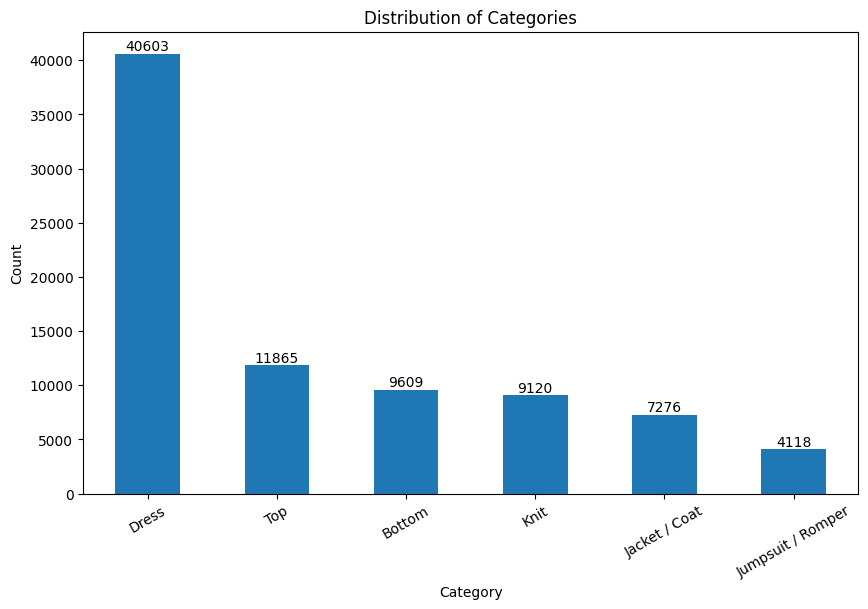

In [ ]:
# Category counts
## This bar plot illustrates the distribution of clothing items across different categories, such as dresses, tops, bottoms, etc.

print("Category Value Counts:")
print(category_counts_relabel)

plt.figure(figsize=(10, 6))
ax = category_counts_relabel.plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=30)

for i in ax.patches:
    plt.text(i.get_x() + i.get_width()/2, i.get_height(), str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.show()


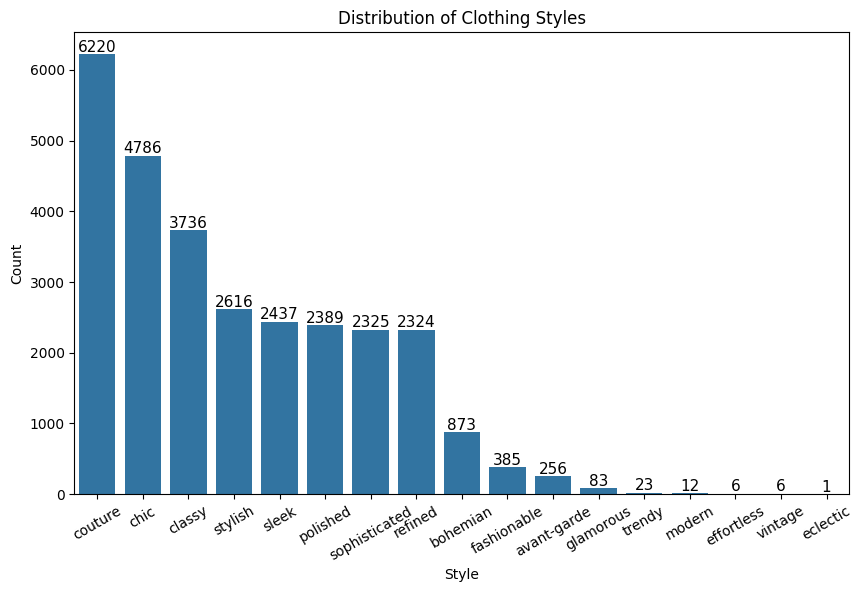

In [ ]:
# Style
## This bar plot visualizes the frequency of each style, such as chic, elegant, modern, etc., indicating the popularity of different fashion styles.

plt.figure(figsize=(10, 6))
sns.countplot(data=inventory_df, x='style', order=inventory_df['style'].value_counts().index)
plt.title('Distribution of Clothing Styles')
plt.xlabel('Style')
plt.ylabel('Count')
plt.xticks(rotation=30)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()



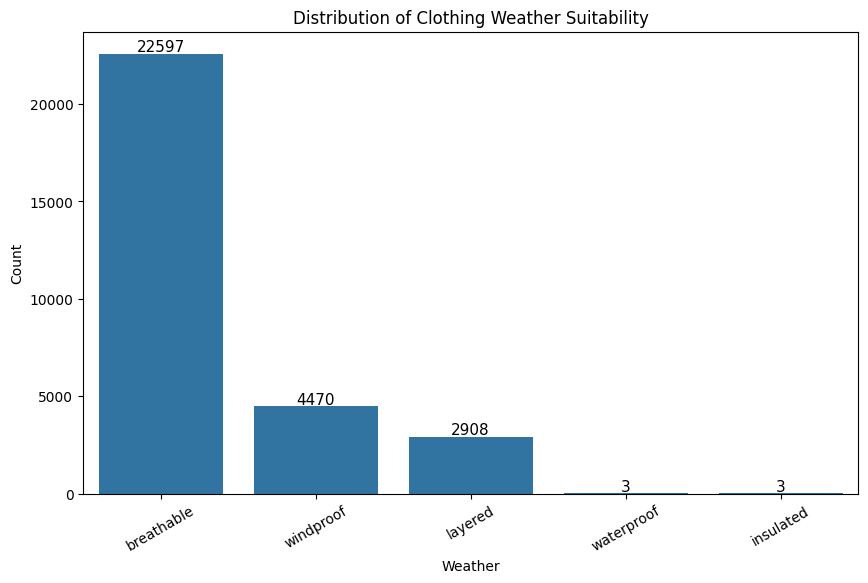

In [ ]:
# Weather
## This bar plot displays the distribution of clothing items based on their suitability for different weather conditions.

plt.figure(figsize=(10, 6))
sns.countplot(data=inventory_df, x='weather', order=inventory_df['weather'].value_counts().index)
plt.title('Distribution of Clothing Weather Suitability')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.xticks(rotation=30)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()



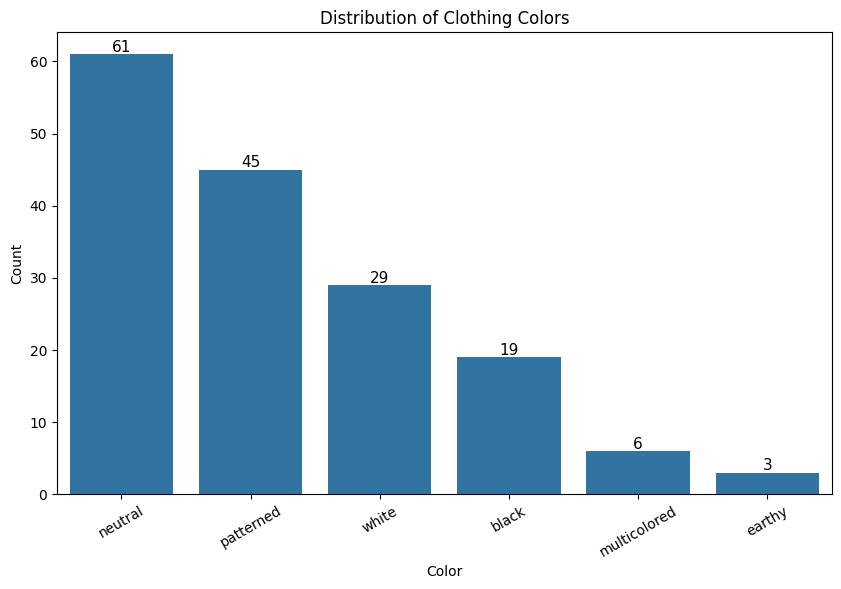

In [ ]:
# Colors
## This bar plot presents the distribution of clothing items according to their colors.

sns.countplot(data=inventory_df, x='color', order=inventory_df['color'].value_counts().index)
plt.title('Distribution of Clothing Colors')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=30)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

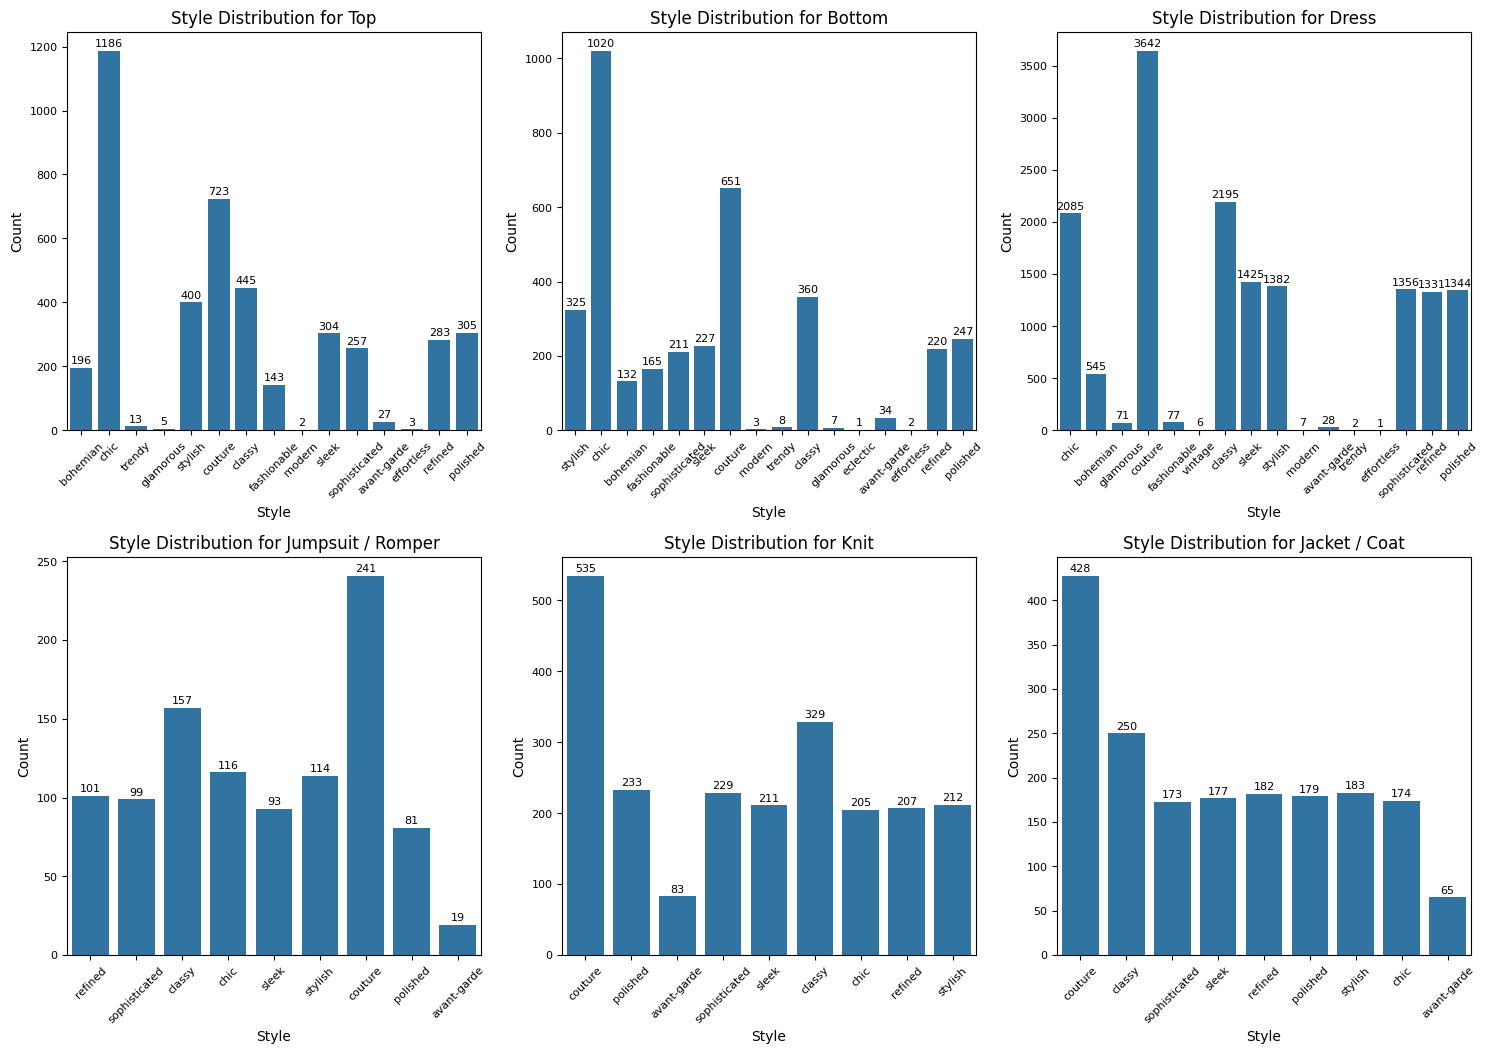

In [ ]:
# Style Distribution for Each Category
## These bar plots depict the distribution of clothing styles within each category (e.g., dresses, tops, bottoms).

category_names = {
    'dresses': 'Dress',
    'top': 'Top',
    'bottom': 'Bottom',
    'knit': 'Knit',
    'jacket_coat': 'Jacket / Coat',
    'jumpsuit_romper': 'Jumpsuit / Romper'
}

unique_categories = inventory_df['category'].nunique()
grid_size = math.ceil(math.sqrt(unique_categories))

# Create a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, category in enumerate(inventory_df['category'].unique()):
    sns.countplot(data=inventory_df[inventory_df['category'] == category], x='style', ax=axes[i])
    axes[i].set_title(f'Style Distribution for {category_names[category]}', fontsize=12)
    axes[i].set_xlabel('Style', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

    for patch in axes[i].patches:
        axes[i].annotate(str(int(patch.get_height())), (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

for j in range(unique_categories, grid_size*grid_size):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


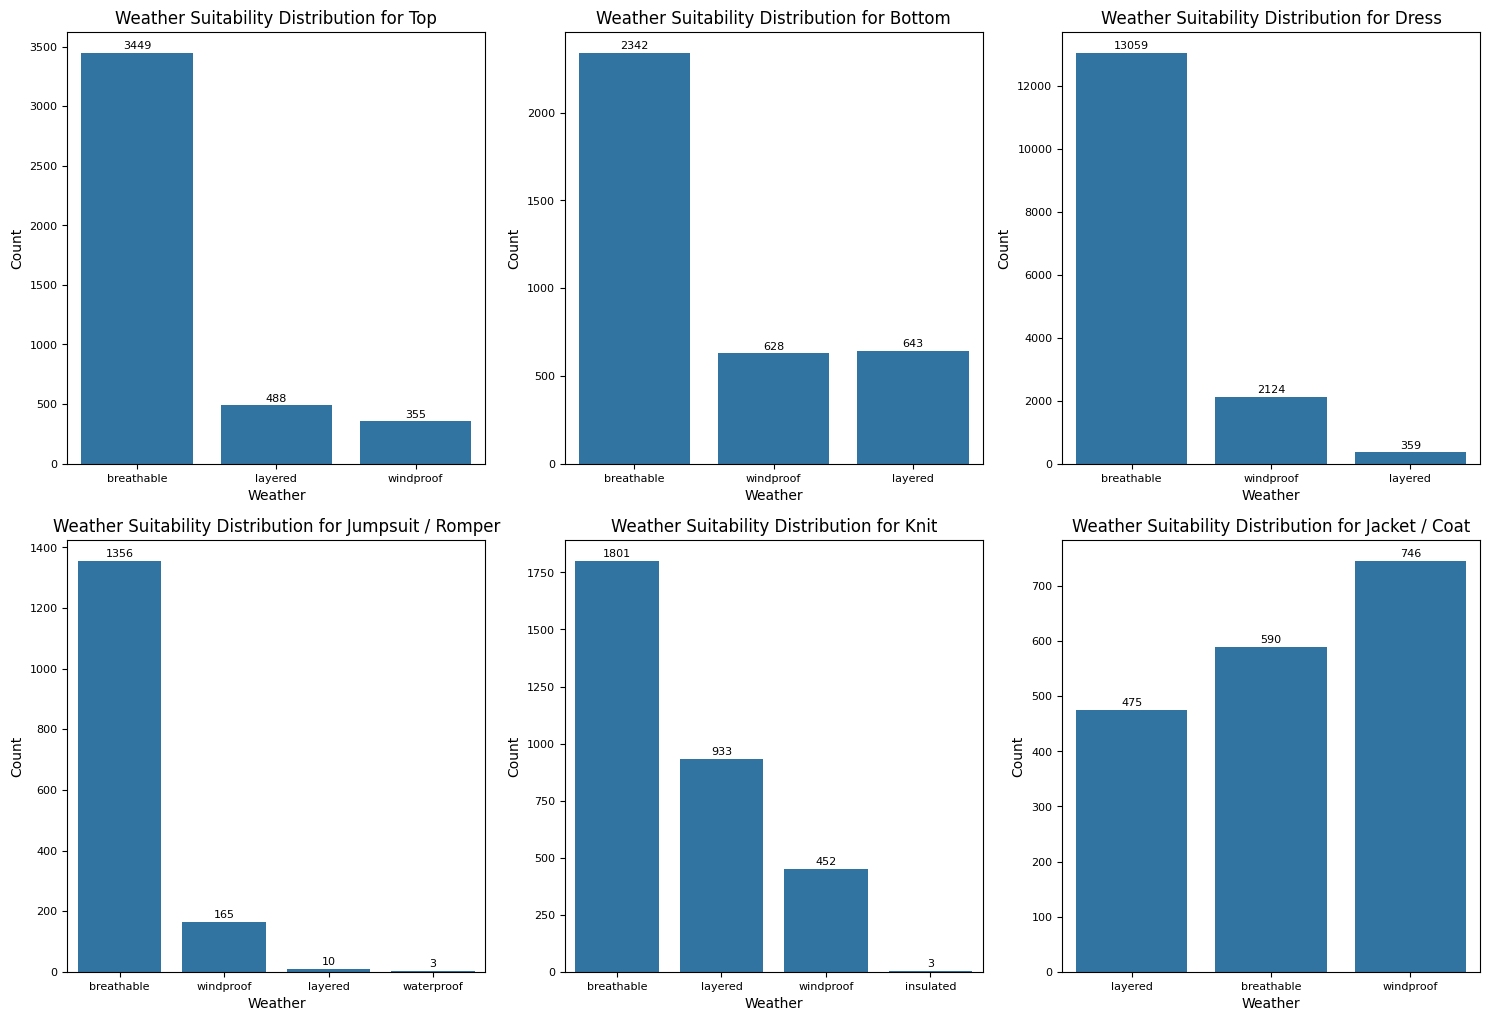

In [ ]:
# Style Distribution for Each Category
## These bar plots demonstrate the distribution of clothing items based on their suitability for different weather conditions within each category.

import math
import matplotlib.pyplot as plt
import seaborn as sns

category_names = {
    'dresses': 'Dress',
    'top': 'Top',
    'bottom': 'Bottom',
    'knit': 'Knit',
    'jacket_coat': 'Jacket / Coat',
    'jumpsuit_romper': 'Jumpsuit / Romper'
}

unique_categories = inventory_df['category'].nunique()
grid_size = math.ceil(math.sqrt(unique_categories))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, category in enumerate(inventory_df['category'].unique()):
    sns.countplot(data=inventory_df[inventory_df['category'] == category], x='weather', ax=axes[i])
    axes[i].set_title(f'Weather Suitability Distribution for {category_names[category]}', fontsize=12)
    axes[i].set_xlabel('Weather', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

    for patch in axes[i].patches:
        axes[i].annotate(str(int(patch.get_height())), (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

for j in range(unique_categories, grid_size*grid_size):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

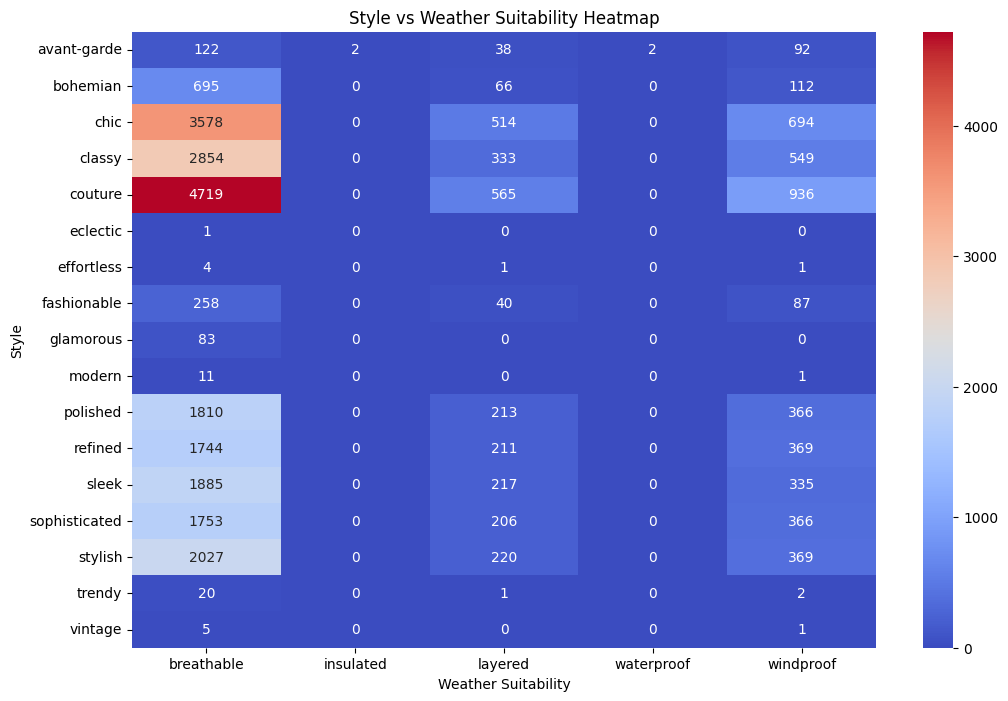

In [ ]:
## This heatmap visualizes the count of clothing items for each combination of style and weather condition.
## It helps identify correlations between fashion styles and weather suitability.

heatmap_data = inventory_df.groupby(['style', 'weather']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Style vs Weather Suitability Heatmap')
plt.xlabel('Weather Suitability')
plt.ylabel('Style')
plt.show()

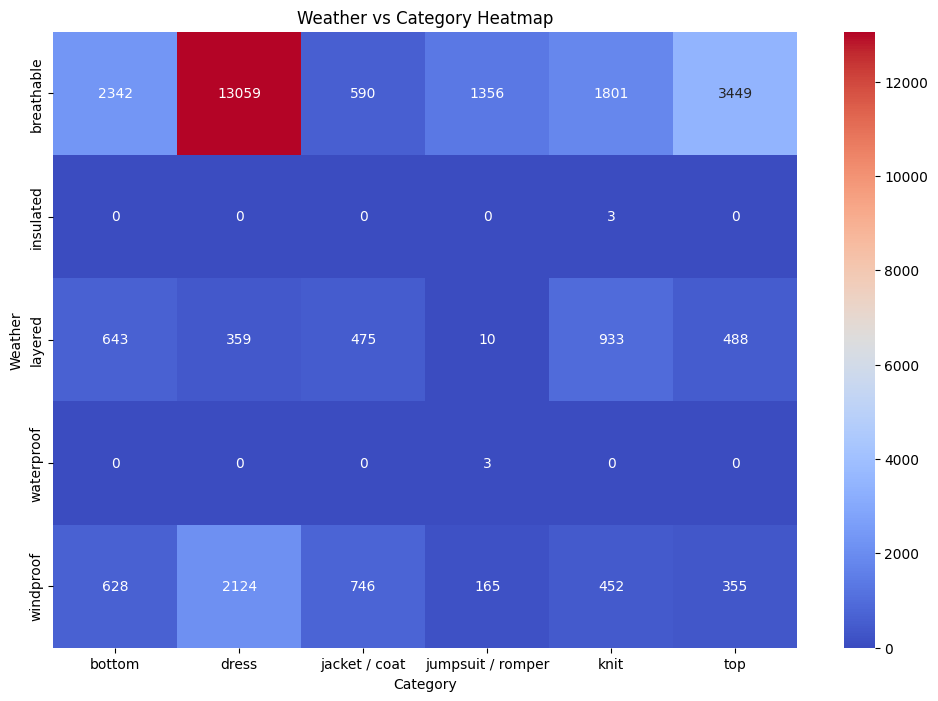

In [ ]:
## This heatmap displays the count of clothing items for each combination of weather condition and category.

category_labels_mapping = {
    'dresses': 'dress',
    'top': 'top',
    'bottom': 'bottom',
    'knit': 'knit',
    'jacket_coat': 'jacket / coat',
    'jumpsuit_romper': 'jumpsuit / romper'
}

# Apply the relabeling to the category column
inventory_df['category_relabel'] = inventory_df['category'].map(category_labels_mapping)

# Create the heatmap
heatmap_data = inventory_df.groupby(['weather', 'category_relabel']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Weather vs Category Heatmap')
plt.xlabel('Category')
plt.ylabel('Weather')
plt.show()


NGROK = Tunnel to the Internet.

Using Flash